In [1]:
import numpy as np
import pandas as pd
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

: 

: 

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(691,256),
            nn.ReLU(True),
            nn.Linear(256,128),
            nn.ReLU(True),
            nn.Linear(128,latent_dim*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,128),
            nn.ReLU(True),
            nn.Linear(128,256),
            nn.ReLU(True),
            nn.Linear(256,691)
        )
    
    def encode(self, x):
        mean_logvar = self.encoder(x)
        mean, log_var = torch.chunk(mean_logvar, 2, dim=1)
        return mean, log_var
    
    def reparaterize(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mean + eps*std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparaterize(mean, log_var)
        return self.decode(z), mean, log_var

In [ ]:
# VAE loss function
def vae_loss(x, x_recon, mean, log_var):
    recon_loss = nn.MSELoss()(x_recon, x)
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return recon_loss + kl_loss

In [ ]:
facial_mixed_noratio_data = pd.read_csv('/Users/jiachenyao/Desktop/Thesis/Preprocessed_data/mix_emo_facial_no_time_noratio.csv')
facial_single_data = pd.read_csv('/Users/jiachenyao/Desktop/Thesis/Preprocessed_data/single_emo_facial_no_time.csv')

In [ ]:
facial_mixed_noratio_string_labels = facial_mixed_noratio_data.iloc[:, 0].values
facial_mixed_noratio_data = facial_mixed_noratio_data.iloc[:, 1:].values

facial_single_string_labels = facial_single_data.iloc[:, 0].values
facial_single_data = facial_single_data.iloc[:, 1:].values

In [ ]:
label_encoder = LabelEncoder()
# Fit and transform the string labels to numeric labels
facial_mixed_noratio_numerical_labels = label_encoder.fit_transform(facial_mixed_noratio_string_labels)
mix_label_mapping = dict(zip(facial_mixed_noratio_numerical_labels, facial_mixed_noratio_string_labels))

# the mapping of string labels to numeric labels
X_train, X_val, y_train, y_val = train_test_split(facial_mixed_noratio_data, facial_mixed_noratio_numerical_labels, test_size=0.2, random_state=42)

# Fit and transform the string labels to numeric labels for signgle emotion data
facial_single_numerical_labels = label_encoder.fit_transform(facial_single_string_labels)
single_label_mapping = dict(zip(facial_single_numerical_labels, facial_single_string_labels))
single_X_train, single_X_val, single_y_train, single_y_val = train_test_split(facial_single_data, facial_single_numerical_labels, test_size=0.2, random_state=42)

In [ ]:
# mix emotion dataset
train_dataset = CustomDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = CustomDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
complete_dataset = CustomDataset(torch.tensor(facial_mixed_noratio_data, dtype=torch.float32), torch.tensor(facial_mixed_noratio_numerical_labels, dtype=torch.long))

# single emotion dataset
single_train_dataset = CustomDataset(torch.tensor(single_X_train, dtype=torch.float32), torch.tensor(single_y_train, dtype=torch.long))
single_val_dataset = CustomDataset(torch.tensor(single_X_val, dtype=torch.float32), torch.tensor(single_y_val, dtype=torch.long))
single_complete_dataset = CustomDataset(torch.tensor(facial_single_data, dtype=torch.float32), torch.tensor(facial_single_numerical_labels, dtype=torch.long))

In [ ]:
# mix emotion dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
complete_loader = DataLoader(complete_dataset, batch_size=32, shuffle=False)

# single emotion dataloader
single_train_loader = DataLoader(single_train_dataset, batch_size=32, shuffle=True)
single_val_loader = DataLoader(single_val_dataset, batch_size=32, shuffle=False)
single_complete_loader = DataLoader(single_complete_dataset, batch_size=32, shuffle=False)

In [ ]:
# Train VAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_dim = 2
mix_vae = VAE(latent_dim).to(device)
single_vae = VAE(latent_dim).to(device)
mix_optimizer = optim.Adam(mix_vae.parameters(), lr=1e-3)
single_optimizer = optim.Adam(single_vae.parameters(), lr=1e-3)
epochs = 50

In [ ]:
def train_test_vae(epochs, train_loader, val_loader, vae, optimizer):
    for epoch in range(epochs):
        vae.train()
        train_loss = 0
        for batch_data, _ in train_loader:
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            x_recon, mean, log_var = vae(batch_data)
            loss = vae_loss(batch_data, x_recon, mean, log_var)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader.dataset)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')


        vae.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_data, _ in val_loader:
                batch_data = batch_data.to(device)
                x_recon, mean, log_var = vae(batch_data)
                loss = vae_loss(batch_data, x_recon, mean, log_var)
                val_loss += loss.item()
            
        val_loss /= len(val_loader.dataset)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}')

In [ ]:
def extract_latent_space(vae, data_loader):
    latent_space = []
    labels = []

    vae.eval()
    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            batch_data = batch_data.to(device)
            mean, log_var = vae.encode(batch_data)
            z = vae.reparaterize(mean, log_var)
            latent_space.append(z.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return np.vstack(latent_space), labels

In [ ]:
train_test_vae(epochs, train_loader, val_loader, mix_vae, mix_optimizer)

Epoch 1, Train Loss: 0.0059
Epoch 1, Val Loss: 0.0018
Epoch 2, Train Loss: 0.0011
Epoch 2, Val Loss: 0.0011
Epoch 3, Train Loss: 0.0009
Epoch 3, Val Loss: 0.0011
Epoch 4, Train Loss: 0.0009
Epoch 4, Val Loss: 0.0010
Epoch 5, Train Loss: 0.0009
Epoch 5, Val Loss: 0.0010
Epoch 6, Train Loss: 0.0009
Epoch 6, Val Loss: 0.0011
Epoch 7, Train Loss: 0.0009
Epoch 7, Val Loss: 0.0010
Epoch 8, Train Loss: 0.0009
Epoch 8, Val Loss: 0.0010
Epoch 9, Train Loss: 0.0009
Epoch 9, Val Loss: 0.0010
Epoch 10, Train Loss: 0.0009
Epoch 10, Val Loss: 0.0010
Epoch 11, Train Loss: 0.0009
Epoch 11, Val Loss: 0.0010
Epoch 12, Train Loss: 0.0009
Epoch 12, Val Loss: 0.0010
Epoch 13, Train Loss: 0.0009
Epoch 13, Val Loss: 0.0010
Epoch 14, Train Loss: 0.0009
Epoch 14, Val Loss: 0.0010
Epoch 15, Train Loss: 0.0009
Epoch 15, Val Loss: 0.0010
Epoch 16, Train Loss: 0.0009
Epoch 16, Val Loss: 0.0010
Epoch 17, Train Loss: 0.0009
Epoch 17, Val Loss: 0.0011
Epoch 18, Train Loss: 0.0009
Epoch 18, Val Loss: 0.0010
Epoch 19, 

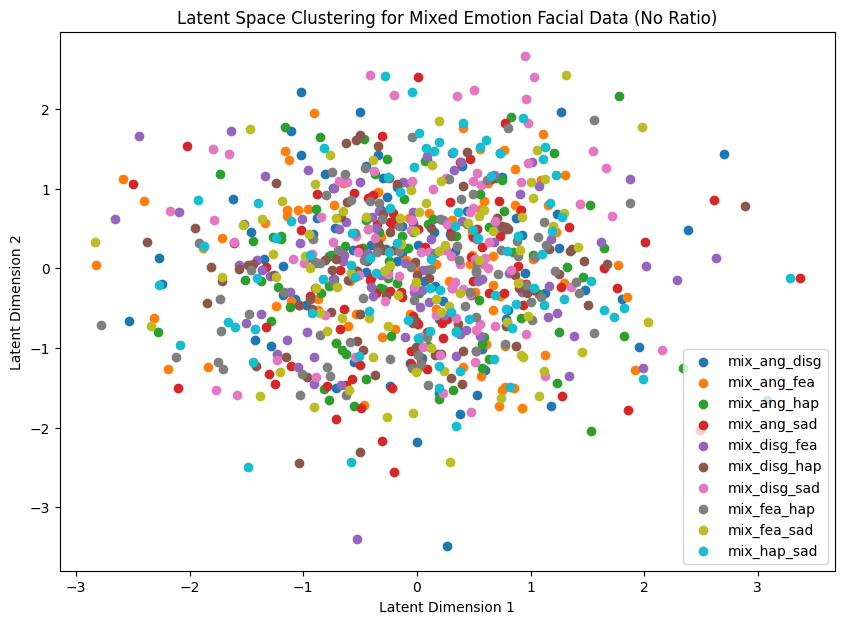

In [ ]:
# Extract latent space from the validation dataset
latent_space, labels = extract_latent_space(mix_vae, complete_loader)

# Plot latent space
#plt.style.use('default')
plt.figure(figsize=(10, 7))
for label in np.unique(labels):
    plt.scatter(latent_space[labels==label, 0], latent_space[labels==label, 1], label=mix_label_mapping[label])
plt.legend()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Clustering for Mixed Emotion Facial Data (No Ratio)')
plt.show()

In [ ]:
train_test_vae(epochs, single_train_loader, single_val_loader, single_vae, single_optimizer)

Epoch 1, Train Loss: 0.0082
Epoch 1, Val Loss: 0.0037
Epoch 2, Train Loss: 0.0022
Epoch 2, Val Loss: 0.0019
Epoch 3, Train Loss: 0.0015
Epoch 3, Val Loss: 0.0016
Epoch 4, Train Loss: 0.0012
Epoch 4, Val Loss: 0.0013
Epoch 5, Train Loss: 0.0010
Epoch 5, Val Loss: 0.0012
Epoch 6, Train Loss: 0.0010
Epoch 6, Val Loss: 0.0012
Epoch 7, Train Loss: 0.0010
Epoch 7, Val Loss: 0.0012
Epoch 8, Train Loss: 0.0009
Epoch 8, Val Loss: 0.0012
Epoch 9, Train Loss: 0.0009
Epoch 9, Val Loss: 0.0012
Epoch 10, Train Loss: 0.0009
Epoch 10, Val Loss: 0.0012
Epoch 11, Train Loss: 0.0009
Epoch 11, Val Loss: 0.0012
Epoch 12, Train Loss: 0.0009
Epoch 12, Val Loss: 0.0011
Epoch 13, Train Loss: 0.0009
Epoch 13, Val Loss: 0.0012
Epoch 14, Train Loss: 0.0009
Epoch 14, Val Loss: 0.0012
Epoch 15, Train Loss: 0.0009
Epoch 15, Val Loss: 0.0012
Epoch 16, Train Loss: 0.0009
Epoch 16, Val Loss: 0.0011
Epoch 17, Train Loss: 0.0009
Epoch 17, Val Loss: 0.0012
Epoch 18, Train Loss: 0.0009
Epoch 18, Val Loss: 0.0011
Epoch 19, 

/var/folders/h4/3nv1jvkx1yl21fmm86sb8ggh0000gn/T/ipykernel_64353/1371805041.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


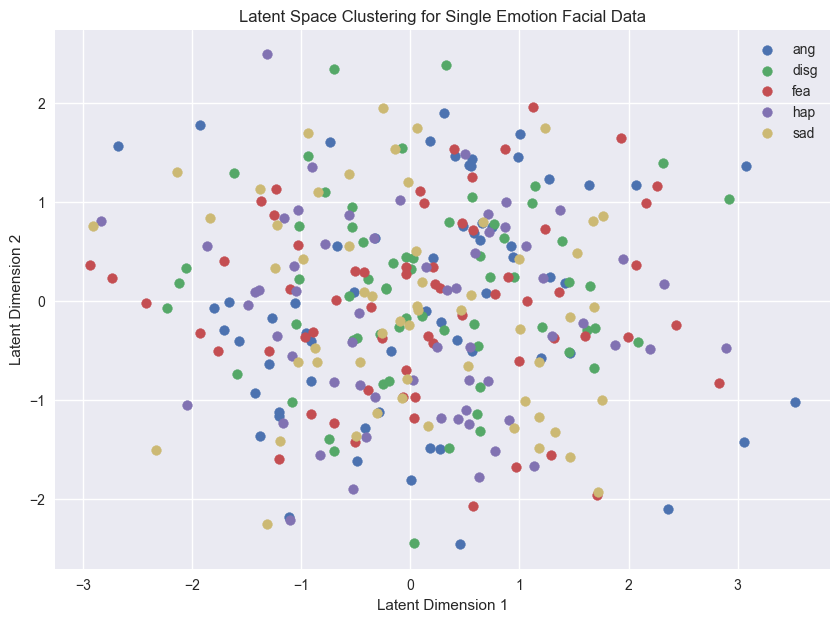

In [ ]:
# Extract latent space from the validation dataset
latent_space, labels = extract_latent_space(single_vae, single_complete_loader)

# Plot latent space
plt.style.use('seaborn')
plt.figure(figsize=(10, 7))
for label in np.unique(labels):
    plt.scatter(latent_space[labels==label, 0], latent_space[labels==label, 1], label=single_label_mapping[label])
plt.legend()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Clustering for Single Emotion Facial Data')
plt.show()